# Equipo: 10
Grupo: 002 Miércoles

### Integrantes
- 1864878 Cerda Serrato Alan René
- 1867341 Cruz Lerma Jorge Antonio
- 1941475 Galindo Vázquez Jesús Alfonso
- 1630606 Valencia González Jesús Eduardo

# Datos históricos del Bitcoin

[Historical Bitcoin Data](https://www.kaggle.com/umeshkumar017/historical-bitcoin-data?select=Bitcoin+Historical+Data+-+In+Rupees.csv)

# La técnica a utilizar es "Series de tiempo".

Esto debido a la naturaleza de los datos (precios y fechas) y a nuestros objetivos.

**Importar las librerías necesarias:**

In [1]:
import pandas as pd
import numpy as np
from dateutil import rrule
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Preparar los datos**

In [2]:
df = pd.read_csv("/content/Bitcoin Historical Data - In Rupees.csv")
df.head(3)

#Fuente de esta celda de código: https://www.kaggle.com/anseldsouza/bitcoin-price-prediction-using-lstm

df.drop(columns = {'Open', 'High', 'Low', 'Vol.', 'Change %'}, inplace = True)

df["Price"] = df["Price"].replace(",", "", regex = True)

df["Date"] = df["Date"].replace(",", "", regex=True)
df["Date"] = df["Date"].replace(" ", "-", regex=True)
df["Date"] = df["Date"].replace("Jan", "01", regex=True)
df["Date"] = df["Date"].replace("Feb", "02", regex=True)
df["Date"] = df["Date"].replace("Mar", "03", regex=True)
df["Date"] = df["Date"].replace("Apr", "04", regex=True)
df["Date"] = df["Date"].replace("May", "05", regex=True)
df["Date"] = df["Date"].replace("Jun", "06", regex=True)
df["Date"] = df["Date"].replace("Jul", "07", regex=True)
df["Date"] = df["Date"].replace("Aug", "08", regex=True)
df["Date"] = df["Date"].replace("Sep", "09", regex=True)
df["Date"] = df["Date"].replace("Oct", "10", regex=True)
df["Date"] = df["Date"].replace("Nov", "11", regex=True)
df["Date"] = df["Date"].replace("Dec", "12", regex=True)

df["Price"] = pd.to_numeric(df["Price"], downcast="float")

df['Date'] = pd.to_datetime(df["Date"], format='%m-%d-%Y')

df.head(3)

,Date,Price
0,2021-08-24,48846.300781
1,2021-08-23,49539.699219
2,2021-08-22,49254.500000


La serie ya tiene el formato correcto y se eliminaron las columnas que no son precios y fechas, ya que no son necesarias para cumplir nuestros objetivos:
> **A)** Principal: Predecir si es viable invertir en el Bitcoin a corto y mediano plazo.

> **B)** Secundario: Predecir si el valor del bitcoin seguirá a la alza.

**Técnica de minería: Series de tiempo**

*Ordenar los datos del más antiguo al más actual*

- Fechas

In [3]:
idx = len(df['Date']) - 1
newListx = []

while (idx >= 0):
  newListx.append(df['Date'][idx])
  idx = idx - 1
x = newListx
df['Date'] = x

- Precios

In [4]:
idy = len(df['Price']) - 1
newListy = []

while (idy >= 0):
  newListy.append(df['Price'][idy])
  idy = idy - 1
y = newListy
df['Price'] = y

**Mostrar gráfica de los precios del Bitcoin**

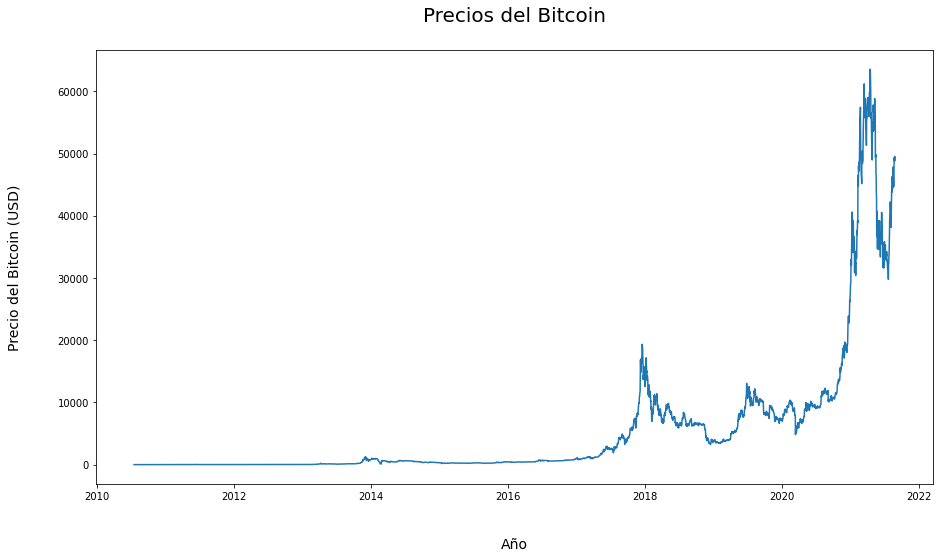

In [5]:
# Fuente de apoyo: https://aprendeconalf.es/docencia/python/manual/matplotlib/
fig, ax = plt.subplots(figsize = (15, 8))
ax.plot(x, y)
plt.ylabel("Precio del Bitcoin (USD)\n\n", fontsize = 14)
plt.xlabel("\n\nAño", fontsize = 14)
plt.title("Precios del Bitcoin\n", fontsize = 20)

# Mostrar
plt.show()

Como vemos, la serie no es estacionaria en media, ya que hay tendencia muy notoria.

**Revisamos la estacionariedad en varianza con la prueba de Dickey-Fuller aumentada:**

In [6]:
# Fuente para saber cuál número es el p-valor: https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
adfuller(df['Price'], autolag='AIC')[1]

0.9646850748823006

El número mostrado anteriormente es el p-valor.

Suponiendo que utilizamos una confianza del 99%, podemos decir que la serie es NO estacionaria en varianza, ya que p-valor > 0.01

Por lo que debemos corregir la serie.

**Corrección 1**

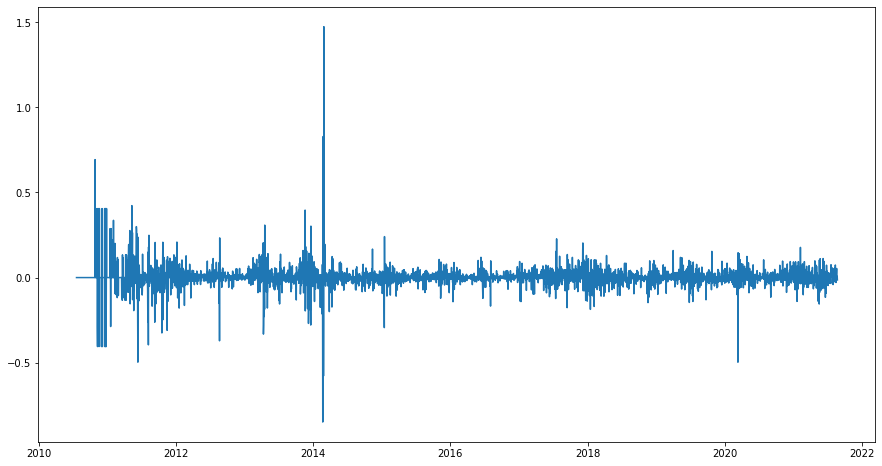

In [7]:
price = np.diff(np.log(df['Price']))

fig, ax = plt.subplots(figsize = (15, 8))
ax.plot(x[1:4056], price)

plt.show()

Revisar estacionariedad en varianza

In [8]:
price = pd.DataFrame(np.diff(np.log(df['Price'])), columns = {"Cor1"})
price.replace([np.inf, -np.inf], np.nan, inplace = True)
price.dropna(axis = 0, how = 'any', inplace = True)
adfuller(price['Cor1'], autolag = 'AIC')[1]

0.0

Ya es estacionaria en varianza, y la gráfica nos dice que también es estacionaria en media (porque no tiene tendencia), por lo que la serie ya es estacionaria.

**Modelado**

- Cálculo del parámetro p

In [9]:
aic = np.inf
a = 0
for i in range(0,10):
  modelo = ARIMA(price, order=(i,0,0))
  modelo_llenado = modelo.fit()
  n = modelo_llenado.aic
  if n < aic:
    aic = n
    a = i

print("Parámetro p =", a, "\nParámetro q = 0\nAIC del modelo =", aic)

Parámetro p = 6 
Parámetro q = 0
AIC del modelo = -10639.253864013383


- Cálculo del parámetro q

In [10]:
aic = np.inf
a = 0
for i in range(1,6):
  modelo = ARIMA(price, order=(6,0,i))
  modelo_llenado = modelo.fit()
  n = modelo_llenado.aic
  if n < aic:
    aic = n
    a = i
    
print("Parámetro p = 6\nParámetro q =", a, "\nAIC del modelo =", aic)

Parámetro p = 6
Parámetro q = 5 
AIC del modelo = -10649.427077501725


El mejor modelo para la serie corregida es un modelo **ARMA(6,5)**.

Pero como se tuvo que hacer una diferenciación para hecer estacionaria a la serie, entonces el modelo para la serie original es un **ARIMA(6,1,5)**.

**Procedemos a mostrar las predicciones**
- Generamos el modelo "ARIMA(6,1,5)" para los datos originales

In [11]:
modelo_original = ARIMA(df['Price'], order = (6, 1, 5))
mod_or_llenado = modelo_original.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


- Cálculo de predicciones (24/Ago/2021 - 31/Dic/2023)

In [12]:
#Fuentes de apoyo: https://www.it-swarm-es.com/es/python/creando-un-rango-de-fechas-en-python/957692062/  

P = pd.DataFrame(mod_or_llenado.forecast(859, alpha = 0.05)[0].tolist(), columns = {'Predicciones'})
D = pd.DataFrame(mod_or_llenado.forecast(859, alpha = 0.05)[2].tolist(), columns = {'Máximo', 'Mínimo'})
Tabla_predicciones = pd.DataFrame(list(rrule.rrule(rrule.DAILY,count=859, dtstart = datetime.strptime("25-08-2021", "%d-%m-%Y"))), columns = {'Fecha'})
Tabla_predicciones['Predicciones'] = P['Predicciones']
Tabla_predicciones['Mínimo (95% de confianza)'] = D['Mínimo']
Tabla_predicciones['Máximo (95% de confianza)'] = D['Máximo']
Tabla_predicciones

,Fecha,Predicciones,Mínimo (95% de confianza),Máximo (95% de confianza)
0,2021-08-25,48740.883407,47744.179997,49737.586816
1,2021-08-26,48972.225925,47606.659559,50337.792292
2,2021-08-27,48811.112276,47127.186151,50495.038400
3,2021-08-28,48492.468974,46521.386475,50463.551473
4,2021-08-29,48624.852124,46404.073571,50845.630677
...,...,...,...,...
854,2023-12-27,59090.656319,29581.097330,88600.215308
855,2023-12-28,59102.796920,29575.984276,88629.609565
856,2023-12-29,59114.876140,29570.819722,88658.932558
857,2023-12-30,59127.010496,29565.720525,88688.300466


Es importante mencionar que las columnas de mínimo y máximo no se refieren a que es el valor mínimo y máximo que el Bitcoin va a tomar cada día. Es un intervalo de confianza en el que se encuentra el valor mostrado en "Predicciones".

- Gráfica de las predicciones

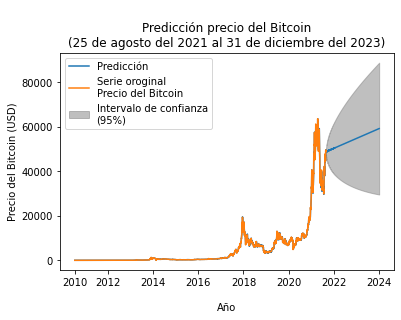

In [19]:
#Fuente de apoyo: https://docs.w3cub.com/statsmodels/generated/statsmodels.tsa.arima_model.arimaresults.plot_predict

mod_or_llenado.plot_predict(1, 4915, alpha = 0.05)
plt.xticks([0, 533, 1263, 1993, 2724, 3454, 4186, 4915], [2010, 2012, 2014, 2016, 2018, 2020, 2022, 2024])
plt.title("\nPredicción precio del Bitcoin\n(25 de agosto del 2021 al 31 de diciembre del 2023)")
plt.xlabel("\nAño")
plt.ylabel("Precio del Bitcoin (USD)")
plt.legend(["Predicción", "Serie oroginal\nPrecio del Bitcoin", "Intervalo de confianza\n(95%)"], loc = "upper left")

Objetivos:
> **A)** Principal: Predecir si es viable invertir en el Bitcoin a corto y mediano plazo.

> **B)** Secundario: Predecir si el valor del bitcoin seguirá a la alza.

Como vemos en la gráfica y la tabla de predicciones, es viable invertir en Bitcoin a corto, mediano e incluso a largo plazo, ya que el valor del Bitcoin seguirá a la alza, lo que generaría ganancias.

# **Métricas de evaluación**

**AIC**

In [20]:
print("El mejor modelo relativo para las correciones es ARMA(6,5)\ny tiene un aic =", modelo_llenado.aic,
      "\n\nEl mejor modelo relativo para los precios del Bitcoin es ARIMA(6,1,5)\ny su AIC es: ", mod_or_llenado.aic)

El mejor modelo relativo para las correciones es ARMA(6,5)
y tiene un aic = -10649.427077501725 

El mejor modelo relativo para los precios del Bitcoin es ARIMA(6,1,5)
y su AIC es:  62081.99196722686


Este es el mejor modelo relativo ya que es el que tiene el menor AIC en comparación a otros modelos revisados con diferentes parámetros p,q.

**Revisar qué tan bueno es el modelo de manera gráfica**
- Generar el modelo

In [21]:
modelo_original = ARIMA(df['Price'], order = (6, 1, 5))
mod_or_llenado = modelo_original.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


- Mostrar los valores estimados comparándolos con los valores reales

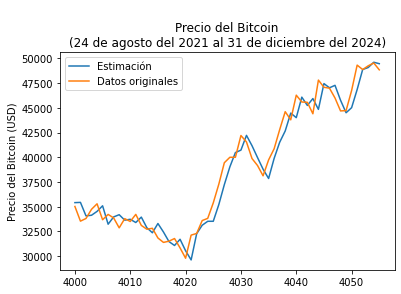

In [22]:
mod_or_llenado.plot_predict(4000, 4055, alpha = 0.15)
#plt.xticks([4000, 4005, 4010, 4015, 4020, 4025, 4030, 4035, 4040, 4045, 4050, 4055],
           #["2021-06-30", "2021-07-05", "2021-07-10", "2021-07-15", "2021-07-20", "2021-07-25", "2021-07-30",
            #"2021-08-04", "2021-08-09", "2021-08-14", "2021-08-19", "2021-08-24"], rotation = 90)
plt.title("\nPrecio del Bitcoin\n(24 de agosto del 2021 al 31 de diciembre del 2024)")
plt.ylabel("Precio del Bitcoin (USD)")
plt.legend(["Estimación", "Datos originales"], loc = "upper left")

Se tomaron solo los datos del 30/Jun/2021 al 24/Ago/2021 para que se vean claramente ambas líneas en la gráfica, y como vemos, las estimaciones se acercan mucho a los datos originales, por lo que podemos decir que **ARIMA(6,1,5)** es es un buen modelo para los precios del Bitcoin.

[Fuente de las métricas de evaluación siguientes](https://polmartisanahuja.com/metricas-de-evaluacion-de-rendimiento-para-predicciones-de-series-temporales/)

**Error absoluto medio**

In [23]:
np.mean(np.abs((mod_or_llenado.fittedvalues + df['Price']) - df['Price']))

59.31673064046315

Como vemos, el error absoluto medio es bajo si tomamos en cuenta la naturaleza de los datos, ya que los precios son en miles de dólares.

Parece ser que el modelo es bueno. Tiene buen ajuste.

**Raíz del error cuadrático medio (RMSE)**

In [24]:
np.sqrt(np.mean(((mod_or_llenado.fittedvalues + df['Price']) - df['Price'])**2))

124.33325549291548

Este error también es bajo, lo que se traduce como un buen ajuste del modelo.

**Error porcentual absoluto medio (MAPE)**

In [25]:
print(round(np.mean(np.abs((mod_or_llenado.fittedvalues + df['Price']) - df['Price']) / (mod_or_llenado.fittedvalues + df['Price'])) * 100, 2),"%", sep = "")

18.88%


Hay poco error porcentual, es decir, los datos estimados se acercan mucho a los datos reales.

# **Conclusiones**

- Primero que nada, los resultados de la técnica resuelven los objetivos planteados, lo cuales son:

 - **Principal:** Predecir si es viable invertir en el Bitcoin a corto y mediano plazo.

 - **Secundario:** Predecir si el valor del bitcoin seguirá a la alza.

 Como vimos antes, el precio del Bitcoin seguirá subiendo, es decir, seguirá a la alza, por lo que es viable invertir en Bitcoin.

- Las métricas de evaluación hacen el trabajo comparable, ya que gracias a estas se puede ver qué tanto se ajusta el modelo.

 Viendo los errores y la gráfica comparativa de estamaciones y datos reales, podemos decir que el modelo se ajusta bien.

- Por último, el hecho de que los errores no sean 0, significa que el modelo no es perfecto. Se ajusta bien, pero no es mejor absoluto, por lo que este puede mejorarse si se comparan más modelo con diferentes parámetros p,q.

 - A continuación se muestra una tabla con la predicción de los precios del Bitcoin de los últimos 5 días (8/Oct/2021 - 13/Oct/2021).

 - La imagen posterior a la tabla muestra el precio real del Bitcoin de los mismos días. [Precio Bitcoin](https://mx.investing.com/crypto/bitcoin/historical-data)

In [26]:
Tabla_predicciones[44:50]

,Fecha,Predicciones,Mínimo (95% de confianza),Máximo (95% de confianza)
44,2021-10-08,49244.900588,42483.827550,56005.973627
45,2021-10-09,49149.230775,42312.118299,55986.343251
46,2021-10-10,49303.440008,42392.107559,56214.772456
47,2021-10-11,49428.653736,42441.933570,56415.373902
48,2021-10-12,49298.597838,42236.760746,56360.434931
49,2021-10-13,49354.011326,42223.409518,56484.613135


Como de dijo antes, es importante dejar claro que las columnas de mínimo y máximo de la tabla de predicciones no se refieren a que es el valor mínimo y máximo que el Bitcoin va a tomar cada día. Es un intervalo de confianza en el que se encuentra el valor mostrado en "Predicciones".

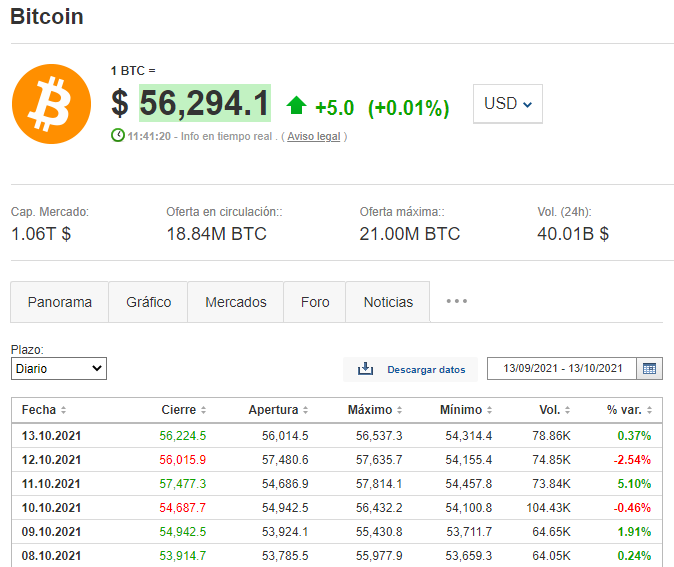

Para ver mejor los datos, los graficamos y tenemos:

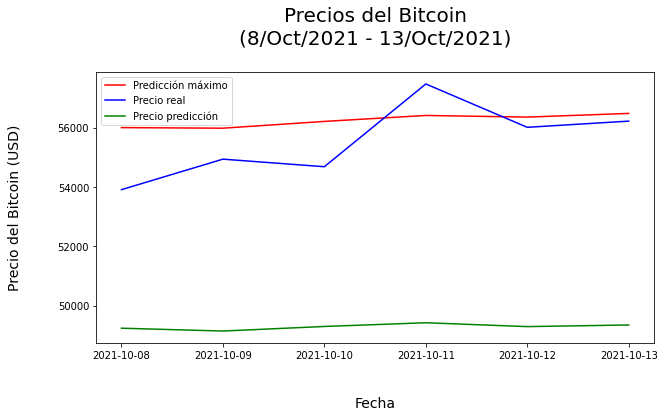

In [27]:
# Fuente de apoyo: https://aprendeconalf.es/docencia/python/manual/matplotlib/
fig, ax = plt.subplots(figsize = (10, 5))
prm = Tabla_predicciones['Máximo (95% de confianza)'][44:50]
pr = Tabla_predicciones['Predicciones'][44:50]
fe = Tabla_predicciones['Fecha'][44:50]
prr = [53914.7, 54942.5, 54687.7, 57477.3, 56015.9, 56224.5]
ax.plot(fe, prm, color = "red", label = "Predicción máximo")
ax.plot(fe, prr, color = "blue", label = "Precio real")
ax.plot(fe, pr, color = "green", label = "Precio predicción")
plt.legend()
plt.ylabel("Precio del Bitcoin (USD)\n\n", fontsize = 14)
plt.xlabel("\n\nFecha", fontsize = 14)
plt.title("Precios del Bitcoin\n(8/Oct/2021 - 13/Oct/2021)\n", fontsize = 20)

# Mostrar
plt.show()

Entonces, al menos para los últimos 5 días, parece ser que el modelo está bien ajustado, ya que el precio real se movió como lo predijo el modelo estimado.

Pero como vemos, se puede mejorar, ya que no todos los datos están en el rango predicho.